In [478]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.model_selection import cross_val_score, KFold,cross_validate
from sklearn.pipeline import Pipeline
from scipy import stats
from time import time
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error,accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import norm, skew, randint
from scipy.special import boxcox1p
import os
from timeit import default_timer as timer
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from catboost import Pool, CatBoostRegressor, cv, CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from fancyimpute import KNN,knn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

## Data Cleaning and EDA

In [296]:
df=pd.read_csv('/Users/yuqidai/Downloads/wine-reviews/winemag-data-130k-v2.csv')

In [297]:
df.head()

Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0                 Etna                NaN       Kerin O’Keefe   
1                  NaN                NaN          Roger Voss   
2    Willamette Valley  Willamette Valley        Paul Gregutt   
3  Lake Michigan Shore                NaN  Alexander Peartree   
4    Willamette Valley  Willamette Valley        Paul Gregutt   

  taster_twitter_handle                                              title  \
0          @kerinokeefe                  Nicosia 2013 Vulkà Bianco  (Etna)   
1            @vossroger      Quinta dos Avidagos 2011 Avidagos Red (Douro)   
2           @paulgwine       Rainstorm 2013 Pinot Gris (Willamette Valley)   
3                   NaN  St. Julian 2013 Reserve Late Harvest Riesling ...   
4           @paulgwine   Sweet Cheeks 2012 Vintner's Reserve Wild Child...   

          variety               winery  
0     White Blend              Nicosia  
1  Portuguese Red  Quinta dos Avidagos  
2      Pinot Gris            Rainstorm  
3        Riesling           St. Julian  
4      Pinot Noir         Sweet Cheeks

In [298]:
print(df.shape)
df=df.drop_duplicates()
df.shape

(129971, 14)


(129971, 14)

In [299]:
#There is no duplicate because there is a index column, so we drop it and check the duplicate again
print(df.shape)
df=df.drop('Unnamed: 0',axis=1).drop_duplicates()
df.shape

(129971, 14)


(119988, 13)

In [300]:
df.describe()

points          price
count  119988.000000  111593.000000
mean       88.442236      35.620747
std         3.092915      42.103728
min        80.000000       4.000000
25%        86.000000      17.000000
50%        88.000000      25.000000
75%        91.000000      42.000000
max       100.000000    3300.000000

In [301]:
#Check out the missing values
df.shape[0] - df.count()

country                     59
description                  0
designation              34545
points                       0
price                     8395
province                    59
region_1                 19560
region_2                 73219
taster_name              24917
taster_twitter_handle    29446
title                        0
variety                      1
winery                       0
dtype: int64

In [302]:
#Percentage of missing
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Total    Percent
region_2               73219  61.021936
designation            34545  28.790379
taster_twitter_handle  29446  24.540787
taster_name            24917  20.766243
region_1               19560  16.301630
price                   8395   6.996533
province                  59   0.049172
country                   59   0.049172
variety                    1   0.000833
winery                     0   0.000000
title                      0   0.000000
points                     0   0.000000
description                0   0.000000

In [303]:
#Region 2 has too many missing values, so we direcly drop it
#Twitter of taster has many missing values and it is not usefull because the info it carried is contained by the taster name, so we drop it
df.drop(['region_2','taster_twitter_handle'],axis=1,inplace=True)

In [304]:
#Number of unique categories
for i in df.columns:
    print('# of categories in {}:'.format(i)+str(df[i].nunique()))

# of categories in country:43
# of categories in description:119955
# of categories in designation:37979
# of categories in points:21
# of categories in price:390
# of categories in province:425
# of categories in region_1:1229
# of categories in taster_name:19
# of categories in title:118840
# of categories in variety:707
# of categories in winery:16757


In [305]:
#The designation column has too many categories and many missing values so it is not useful to us
#We can use extract important info from description and title so we keep them
df.drop(['designation'],axis=1,inplace=True)

In [306]:
df.shape[0] - df.count()

country           59
description        0
points             0
price           8395
province          59
region_1       19560
taster_name    24917
title              0
variety            1
winery             0
dtype: int64

In [307]:
#drop few missing instances
df.dropna(subset=['province'], inplace = True)
df.dropna(subset=['country'], inplace = True)
df.dropna(subset=['variety'], inplace = True)
df.dropna(subset=['price'], inplace = True)

In [308]:
df.shape[0] - df.count()

country            0
description        0
points             0
price              0
province           0
region_1       17957
taster_name    23272
title              0
variety            0
winery             0
dtype: int64

In [309]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

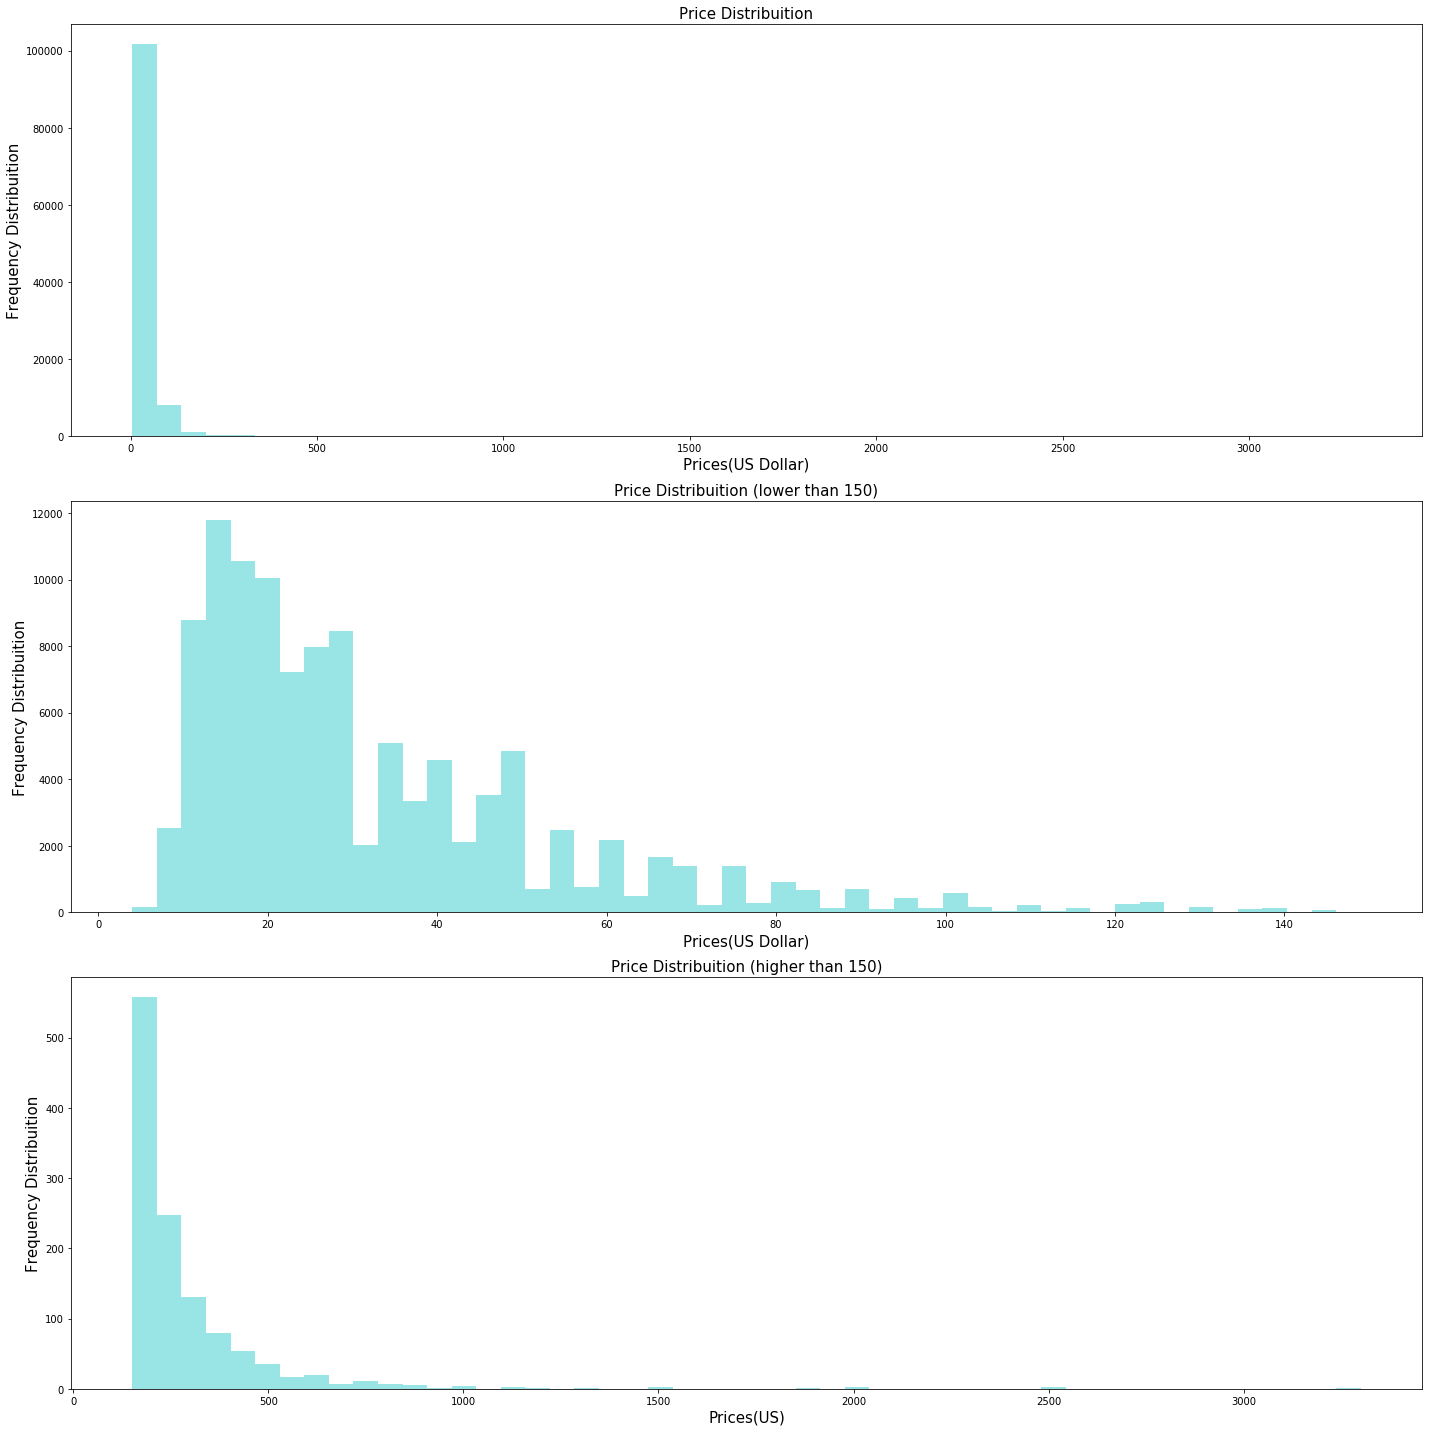

In [310]:
#Price distribution
plt.figure(figsize=(20,20))

p = plt.subplot(311)
p = sns.distplot(df['price'],color='c',kde=False)
p.set_title("Price Distribuition", fontsize=15)
p.set_xlabel("Prices(US Dollar)", fontsize=15)
p.set_ylabel("Frequency Distribuition", fontsize=15)

p = plt.subplot(312)
p = sns.distplot(df[df['price'] < 150]['price'],color='c',kde=False)
p.set_title("Price Distribuition (lower than 150)", fontsize=15)
p.set_xlabel("Prices(US Dollar)", fontsize=15)
p.set_ylabel("Frequency Distribuition", fontsize=15)

p = plt.subplot(313)
p = sns.distplot(df[df['price'] > 150]['price'],color='c',kde=False)
p.set_title("Price Distribuition (higher than 150)", fontsize=15)
p.set_xlabel("Prices(US)", fontsize=15)
p.set_ylabel("Frequency Distribuition", fontsize=15)
plt.tight_layout()
plt.show()

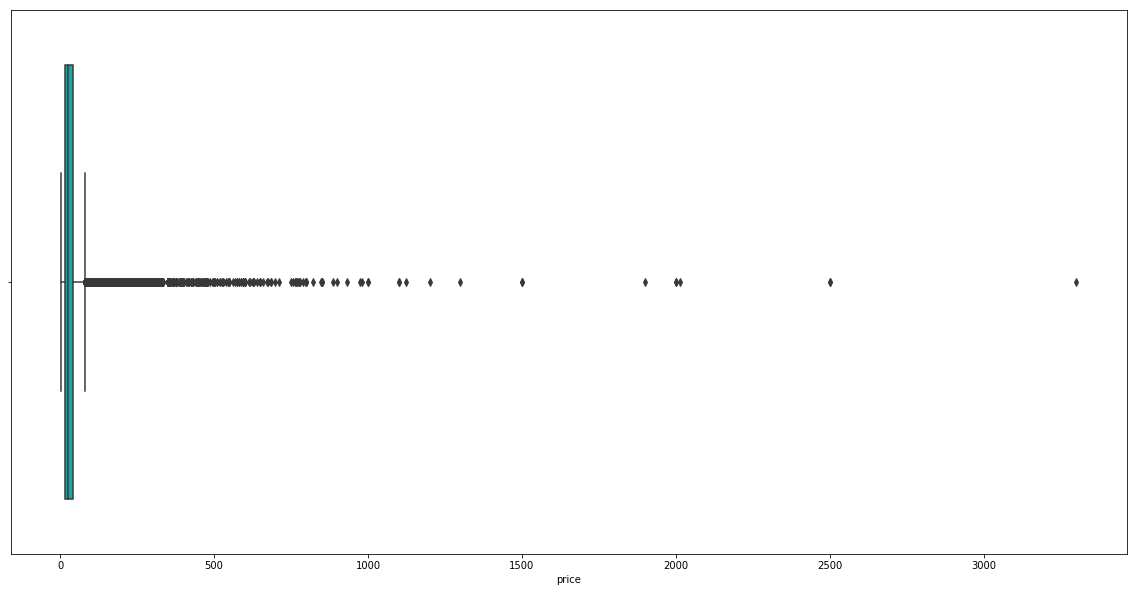

In [311]:
plt.figure(figsize=(20,10))
sns.boxplot(df['price'],color='c')

14

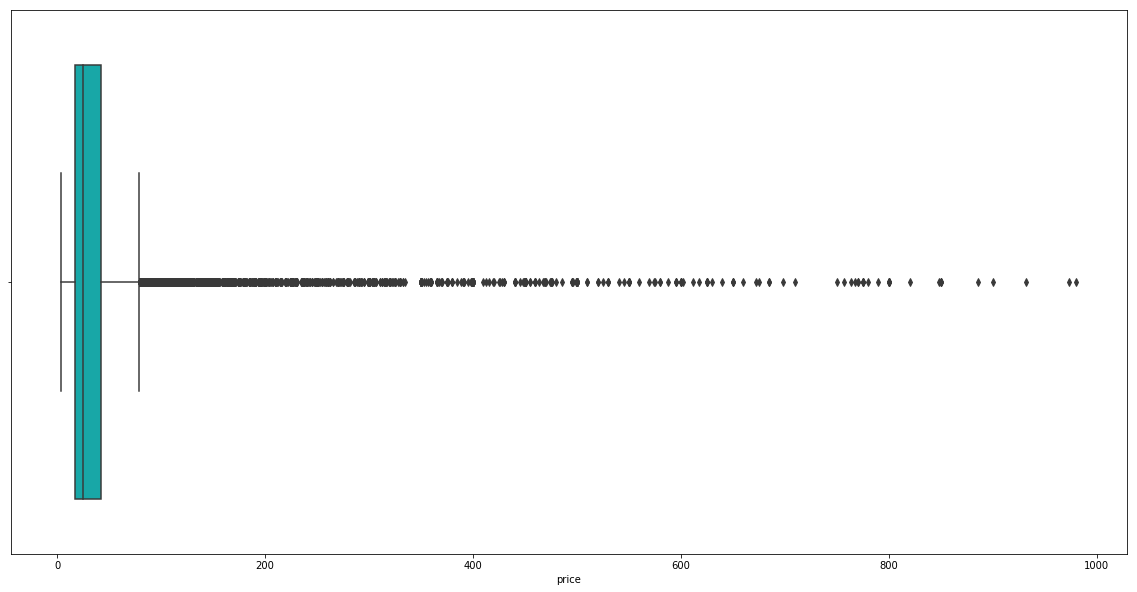

In [312]:
plt.figure(figsize=(20,10))
sns.boxplot(df[df['price']<1000]['price'],color='c')
df[df['price']>1000].shape[0]

Text(0,0.5,'Count')

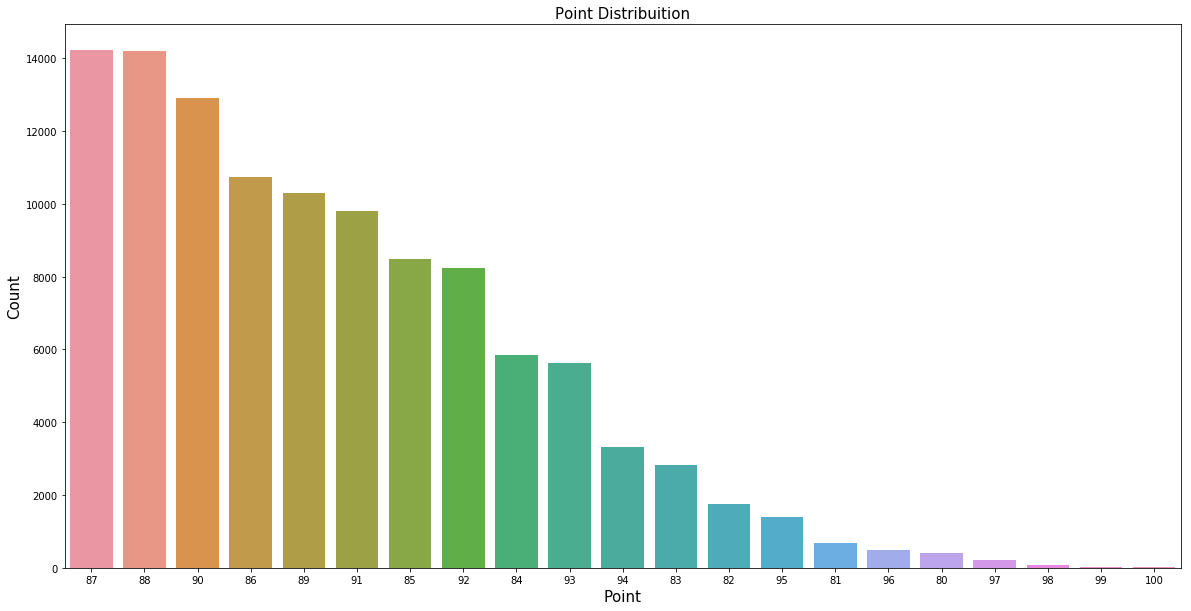

In [313]:
#Point distribution
plt.figure(figsize=(20,10))
p = sns.countplot(df['points'],order = df['points'].value_counts().index)
p.set_title("Point Distribuition", fontsize=15)
p.set_xlabel("Point", fontsize=15)
p.set_ylabel("Count", fontsize=15)

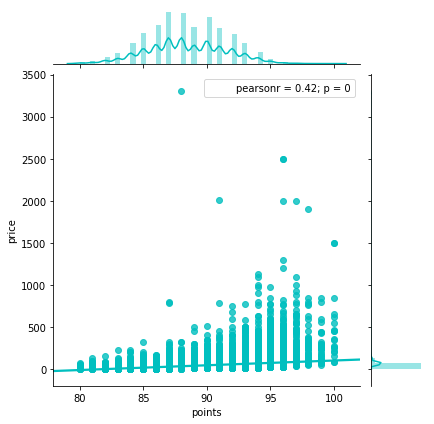

In [314]:
#price and point relationship
sns.jointplot("points", "price", data=df, kind="reg",color='c')

Text(0,0.5,'Count')

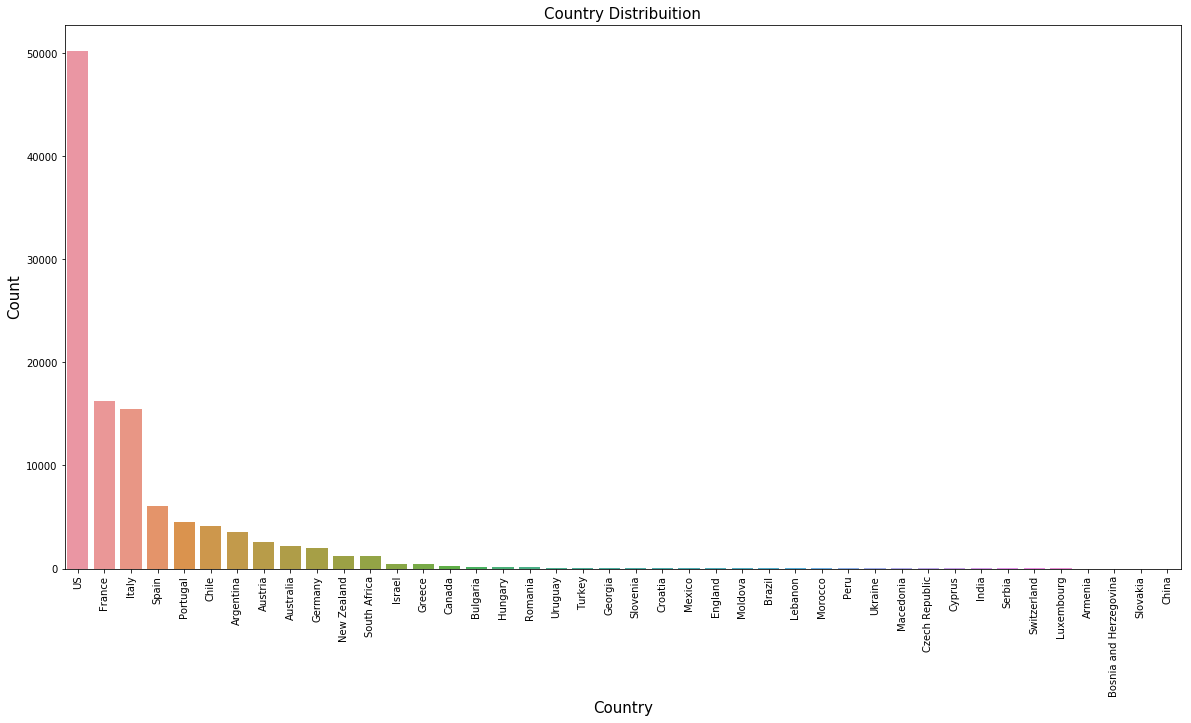

In [315]:
#Country distribution
plt.figure(figsize=(20,10))
p = sns.countplot(df['country'],order = df['country'].value_counts().index)
p.set_xticklabels(p.get_xticklabels(),rotation=90)
p.set_title("Country Distribuition", fontsize=15)
p.set_xlabel("Country", fontsize=15)
p.set_ylabel("Count", fontsize=15)

Text(0,0.5,'Count')

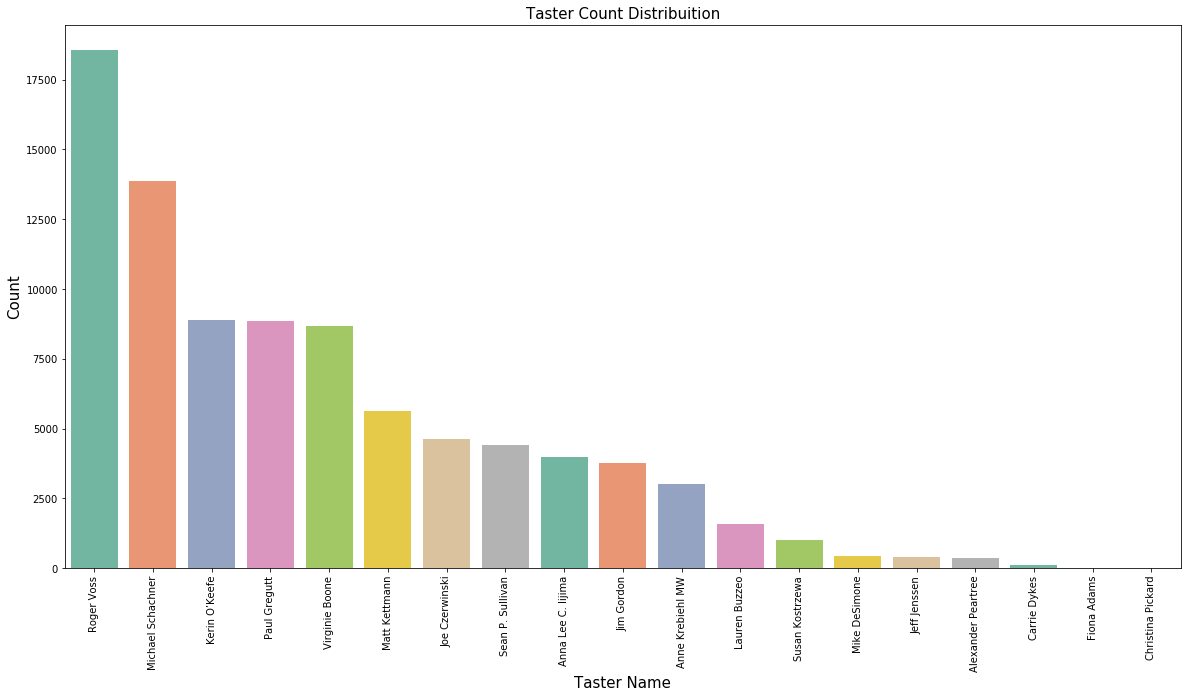

In [316]:
#Taster distribution
#Who is Roger Voss?
plt.figure(figsize=(20,10))
p = sns.countplot(df['taster_name'],order = df['taster_name'].value_counts().index,palette='Set2')
p.set_xticklabels(p.get_xticklabels(),rotation=90)
p.set_title("Taster Count Distribuition", fontsize=15)
p.set_xlabel("Taster Name", fontsize=15)
p.set_ylabel("Count", fontsize=15)

In [317]:
text = " ".join(review for review in df.description)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 27378924 words in the combination of all review.


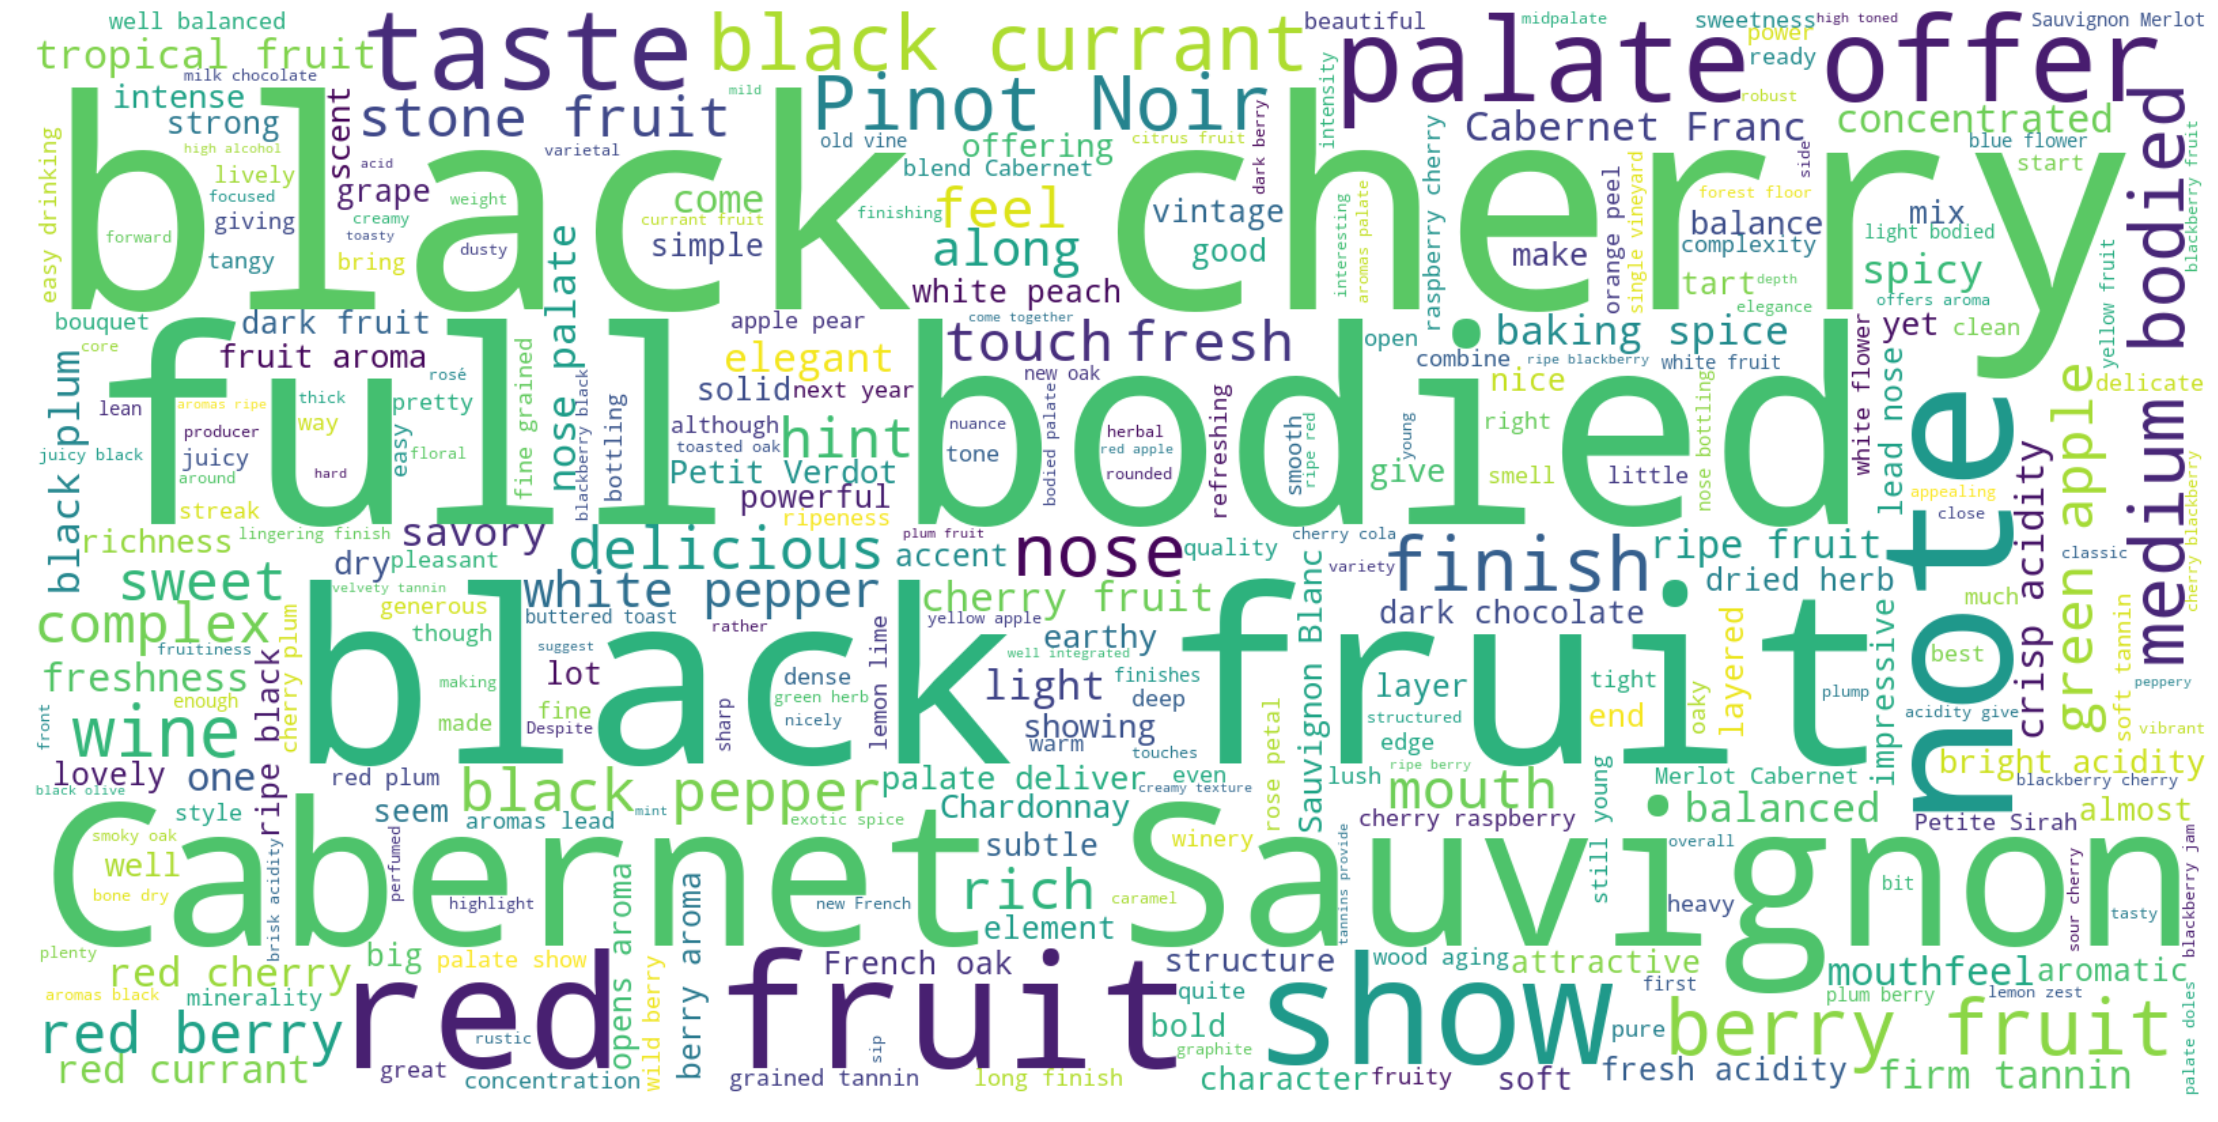

In [318]:
#Word cloud of the description
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "wine", "flavor", "flavors"])
plt.figure(figsize=(40,20))
# Generate a word cloud image
wordcloud = WordCloud(width=1600,height=800,stopwords=stopwords, background_color="white",max_words=300).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [319]:
text = " ".join(review for review in df.title)
print ("There are {} words in the combination of all title.".format(len(text)))

There are 6002412 words in the combination of all title.


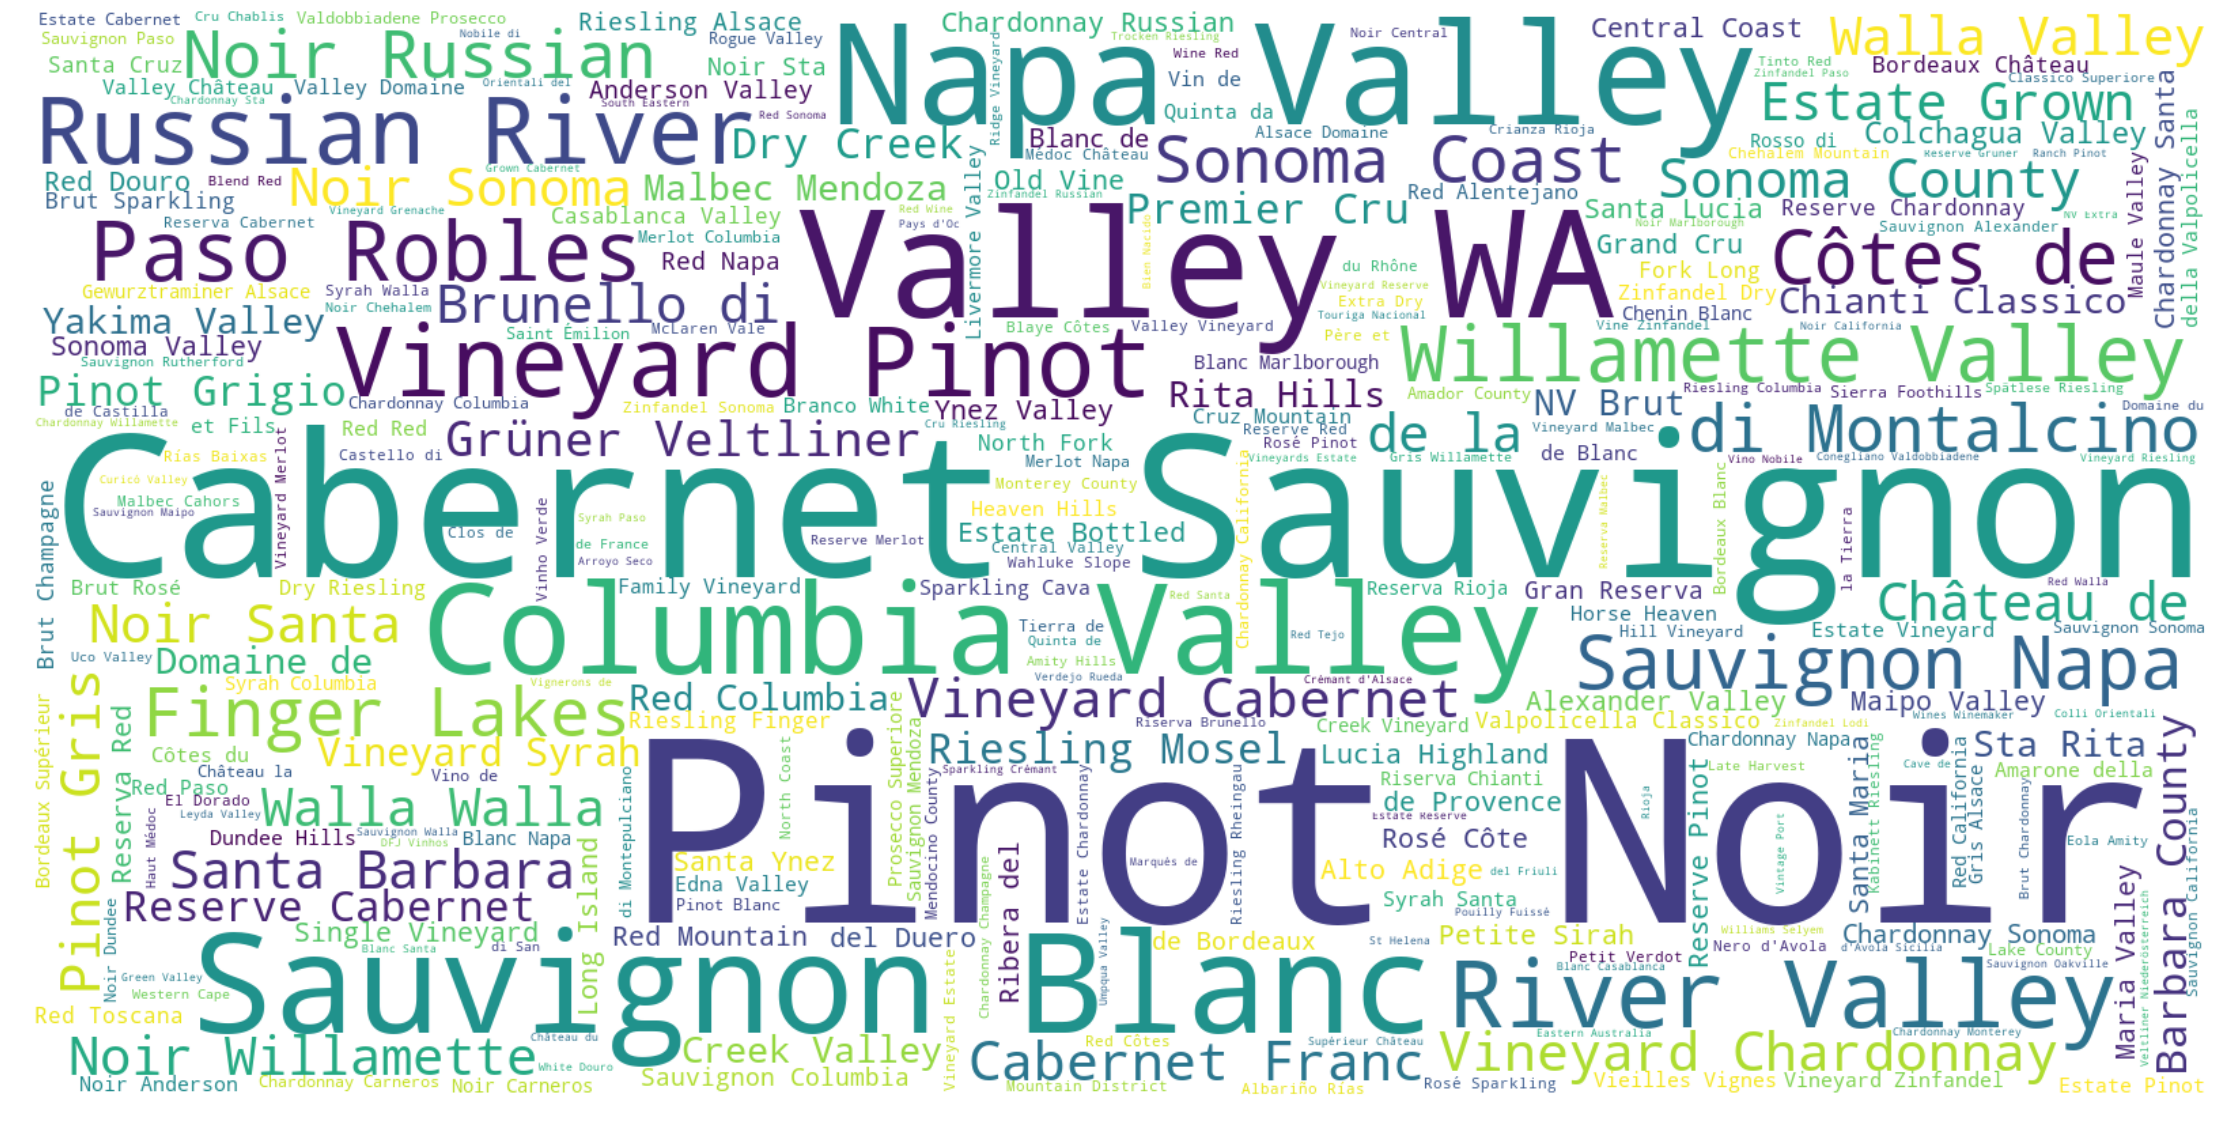

In [320]:
#Word Cloud of the title
stopwords = set(STOPWORDS)
plt.figure(figsize=(40,20))
# Generate a word cloud image
wordcloud = WordCloud(width=1600,height=800,stopwords=stopwords, background_color="white",max_words=300).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Feature Engineering

In [321]:
#Extract year Info from the title, since there are instances where there are multiple number in the titles, we extract the one that is closer to 2000
#For those titles with out year info, we assign a 0 to it and clean them out afterwards.
year=[]
for j in range(df.shape[0]):
    possible_year=[]
    for i in df.iloc[j]['title'].split():
            try:
                result=int(i)
                possible_year.append(result)
            except ValueError:
                pass
    if len(possible_year)==0:
        possible_year.append(0)
    try:
        most_possible_year=min(possible_year, key=lambda x:abs(x-2000))
    except ValueError:
                pass
    year.append(most_possible_year)
    
df['Year']=year

In [322]:
df.head()

country                                        description  points  price  \
1  Portugal  This is ripe and fruity, a wine that is smooth...      87   15.0   
2        US  Tart and snappy, the flavors of lime flesh and...      87   14.0   
3        US  Pineapple rind, lemon pith and orange blossom ...      87   13.0   
4        US  Much like the regular bottling from 2012, this...      87   65.0   
5     Spain  Blackberry and raspberry aromas show a typical...      87   15.0   

         province             region_1         taster_name  \
1           Douro                  NaN          Roger Voss   
2          Oregon    Willamette Valley        Paul Gregutt   
3        Michigan  Lake Michigan Shore  Alexander Peartree   
4          Oregon    Willamette Valley        Paul Gregutt   
5  Northern Spain              Navarra   Michael Schachner   

                                               title             variety  \
1      Quinta dos Avidagos 2011 Avidagos Red (Douro)      Portuguese Red   
2      Rainstorm 2013 Pinot Gris (Willamette Valley)          Pinot Gris   
3  St. Julian 2013 Reserve Late Harvest Riesling ...            Riesling   
4  Sweet Cheeks 2012 Vintner's Reserve Wild Child...          Pinot Noir   
5  Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...  Tempranillo-Merlot   

                winery  Year  
1  Quinta dos Avidagos  2011  
2            Rainstorm  2013  
3           St. Julian  2013  
4         Sweet Cheeks  2012  
5               Tandem  2011

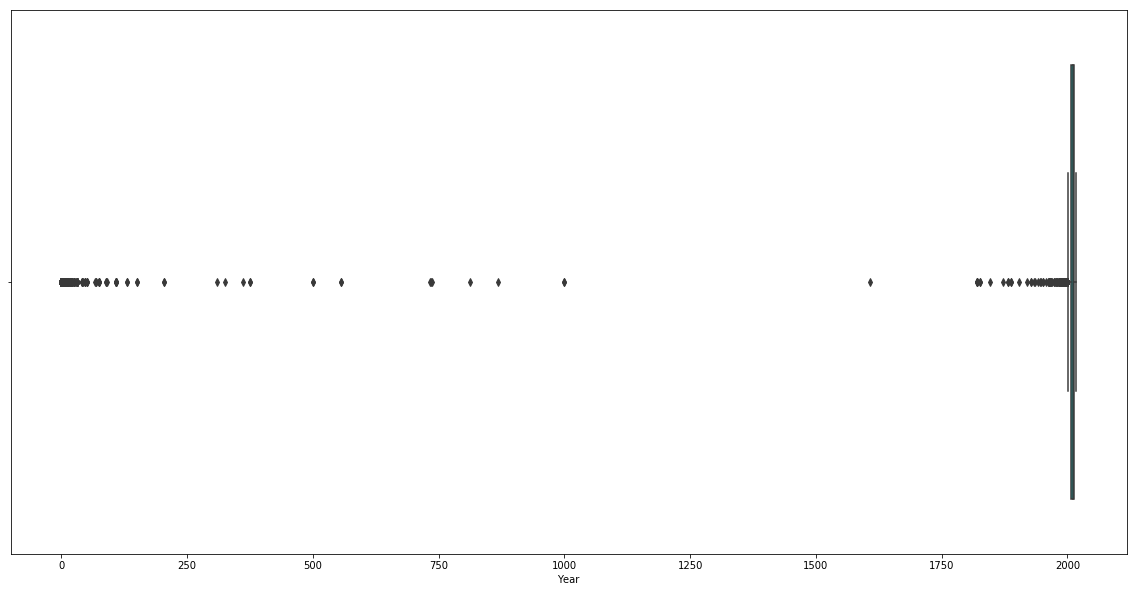

In [323]:
plt.figure(figsize=(20,10))
sns.boxplot(df['Year'],color='c')

In [324]:
df[df['Year']<1800][['price','title','Year']].head(10)

price                                              title  Year
63    58.0          Roland Champion NV Brut Rosé  (Champagne)     0
69    55.0                   Collet NV Brut Rosé  (Champagne)     0
237   18.0  Consorzio Vini Tipici di San Marino NV Moscato...     0
315   15.0  Bellussi NV Extra Dry  (Prosecco di Valdobbiad...     0
326   15.0  Marsuret NV Extra Dry  (Prosecco di Valdobbiad...     0
332   19.0  Sommariva NV Palazzo Rosso Brut  (Prosecco di ...     0
333   18.0  Spagnol NV Col del Sas Extra Dry  (Prosecco di...     0
334   42.0        Jacquart NV Mosaïque Rosé Brut  (Champagne)     0
342   11.0                       Bellisco NV Sparkling (Cava)     0
345  350.0  Chambers Rosewood Vineyards NV Rare Muscat (Ru...     0

In [325]:
#The titles of few wines have no specific year but have something like 20 years or 10 Anos 
#but some have no year info at all
#remove those instances with no year
print('Number of points with no year in the title: {}'.format(df[df['Year']<1950]['title'].shape[0]))
print('Ratio of outliers removed: {}'.format(df[df['Year']<1950]['title'].shape[0]/df.shape[0]))
df=df[df['Year']>1950]

Number of points with no year in the title: 3845
Ratio of outliers removed: 0.03447286550651353


Text(0,0.5,'Count')

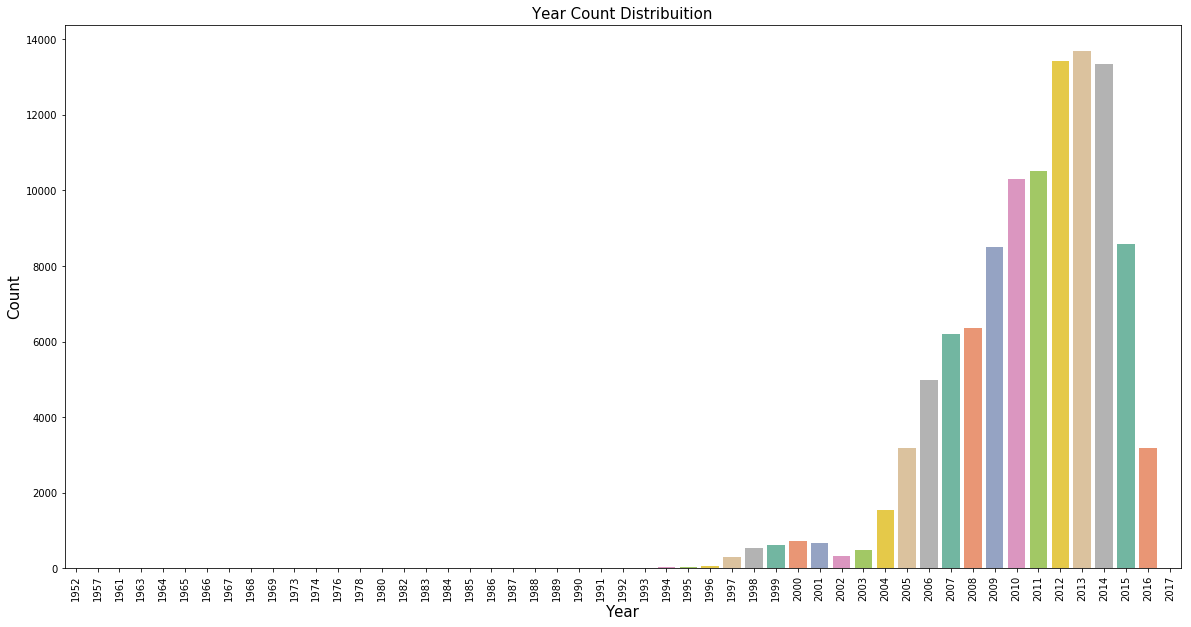

In [326]:
#Distribution of Year afterwards
plt.figure(figsize=(20,10))
p = sns.countplot(df['Year'],palette='Set2')
p.set_xticklabels(p.get_xticklabels(),rotation=90)
p.set_title("Year Count Distribuition", fontsize=15)
p.set_xlabel("Year", fontsize=15)
p.set_ylabel("Count", fontsize=15)

In [327]:
#Create a quality cutoff to indicate the quality of the wine 
#score above 90 stands for the high standard of the wine and can truly preserve the value
qualityCutoff = 90
pointRange = df.points.values.tolist()
quality = []
for point in pointRange:
    if point >= qualityCutoff:
        quality.append(1)
    else:
        quality.append(0)
df['Quality']=quality

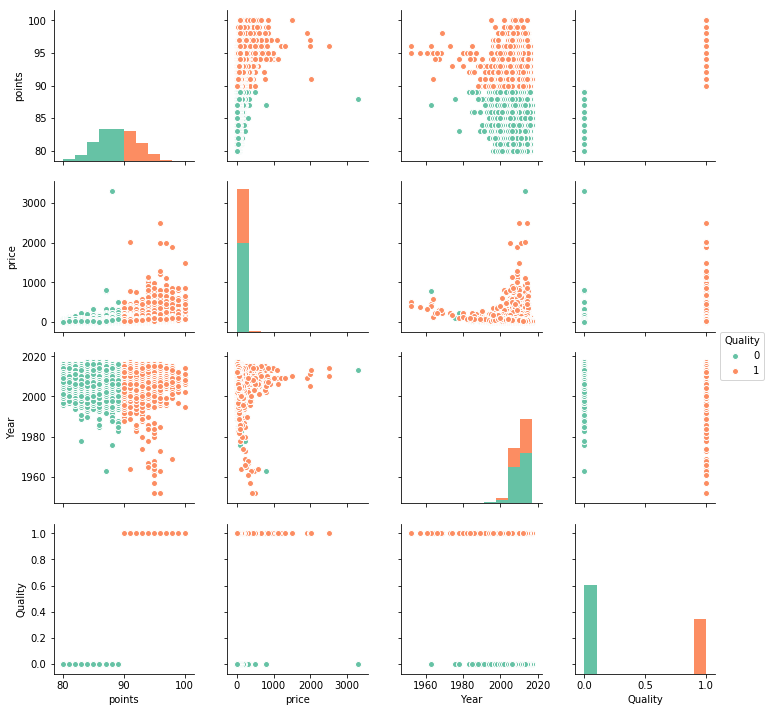

In [328]:
# Create pair plot
sns.pairplot(df.iloc[:,[2,3,10,11]],hue='Quality',palette='Set2')

In [329]:
df.shape[0]-df.count()

country            0
description        0
points             0
price              0
province           0
region_1       17539
taster_name    22395
title              0
variety            0
winery             0
Year               0
Quality            0
dtype: int64

In [330]:
df.shape

(107692, 12)

In [331]:
#Encoding the categorical columns
def labelCategoryData(df,label):
    labels = LabelEncoder().fit(np.unique(df[label].values))
    df[label+'_enc'] = labels.transform(df[label])
    return(df)
labels = ['country','variety','winery','province']
for label in labels:
    df = labelCategoryData(df,label)
df=df.drop(['country','variety','winery','province','title'],axis=1)

In [334]:
df.head()

description  points  price  \
1  This is ripe and fruity, a wine that is smooth...      87   15.0   
2  Tart and snappy, the flavors of lime flesh and...      87   14.0   
3  Pineapple rind, lemon pith and orange blossom ...      87   13.0   
4  Much like the regular bottling from 2012, this...      87   65.0   
5  Blackberry and raspberry aromas show a typical...      87   15.0   

              region_1         taster_name  Year  Quality  country_enc  \
1                  NaN          Roger Voss  2011        0           30   
2    Willamette Valley        Paul Gregutt  2013        0           39   
3  Lake Michigan Shore  Alexander Peartree  2013        0           39   
4    Willamette Valley        Paul Gregutt  2012        0           39   
5              Navarra   Michael Schachner  2011        0           36   

   variety_enc  winery_enc  province_enc  
1          436       11882           106  
2          422       11941           261  
3          464       13229           212  
4          426       13449           261  
5          571       13528           255

In [440]:
#define the function to get cross validation result
def GetScore(model,name,X_train,y_train):
    clf=model.fit(X_train,y_train)
    results=cross_val_score(clf,X_train,y_train,cv=5)
    print(name+" Score: %.4f (%.4f)" % (results.mean(), results.std()))
    
#define the function to get top 10 results from randomized search   
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
#Here we try different methos to deal with missing values and compare their effect to the model to decide which to use

In [604]:
#Drop rows with NaN
df1=df.dropna()
labels = ['region_1','taster_name']
for label in labels:
    df1 = labelCategoryData(df1,label)
df1=df1.drop(['region_1','taster_name'],axis=1)
X_train1=df1.drop(['description','Quality','points'],axis=1)
y_train1=df1['Quality']
X_train1.shape

(68098, 8)

In [605]:
GetScore(lgb.LGBMClassifier(),'LGBM',X_train1,y_train1)

LGBM Score: 0.7698 (0.0059)


In [606]:
#Drop Columns with "NaN"
X_train2=df.drop(['description','Quality','points','region_1','taster_name'],axis=1)
y_train2=df['Quality']
X_train2.shape

(107692, 6)

In [607]:
GetScore(lgb.LGBMClassifier(),'LGBM',X_train2,y_train2)

LGBM Score: 0.7745 (0.0070)


In [608]:
#Fill NaN with "NaN"
df2=df.fillna('NaN')
labels = ['region_1','taster_name']
for label in labels:
    df2 = labelCategoryData(df2,label)
df2=df2.drop(['region_1','taster_name'],axis=1)
X_train3=df2.drop(['description','Quality','points'],axis=1)
y_train3=df2['Quality']
X_train3.shape

(107692, 8)

In [609]:
GetScore(lgb.LGBMClassifier(),'LGBM',X_train3,y_train3)

LGBM Score: 0.7787 (0.0075)


In [ ]:
#We can see that the third method is better than other two and it preserve more info so we choose to use it

## Model Building

### Model 1 (NLP)

In [456]:
#Use description to predict quality
X=df2['description']
y=df2['Quality']

In [457]:
#use TF-IDF to transform the description
from sklearn.feature_extraction.text import TfidfVectorizer
TV=TfidfVectorizer(stop_words='english',binary=True,ngram_range=(1,2))
TV.fit(X)
X=TV.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=7)

In [415]:
#Check out baseline accuracy （5 folds cv accuracy）
GetScore(lgb.LGBMClassifier(),'LightGBM',X_train,y_train)
GetScore(LogisticRegression(),'LR',X_train,y_train)
GetScore(BernoulliNB(),'BN',X_train,y_train)

LightGBM Score: 0.8286 (0.0032)
LR Score: 0.8293 (0.0040)
BN Score: 0.7990 (0.0022)


Text(0.5,1,'Receiver operating characteristic')

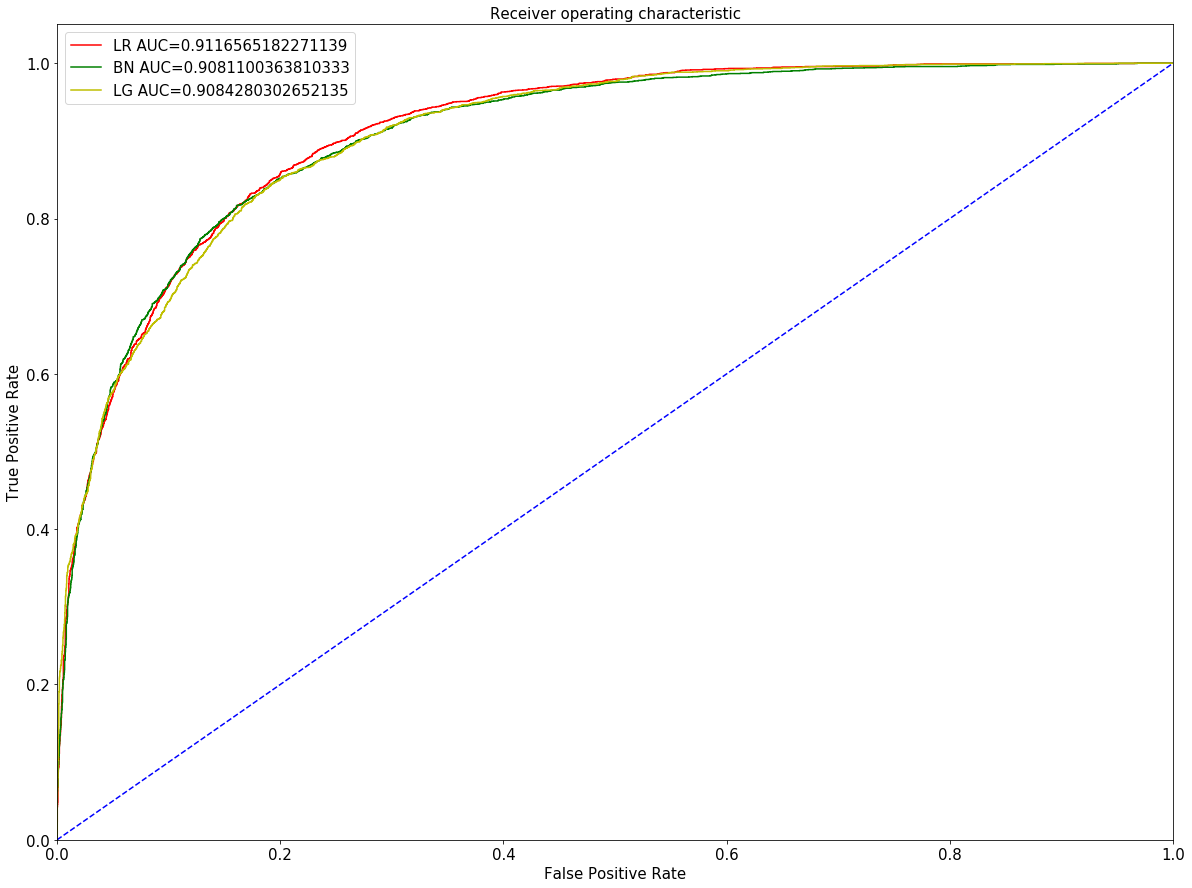

In [416]:
from sklearn.metrics import roc_curve, auc
#Draw AUC curve of different models
LR=LogisticRegression()
BN=BernoulliNB()
LG=lgb.LGBMClassifier()

LR.fit(X_train,y_train)
fpr1,tpr1,threshold1=roc_curve(y_val,LR.predict_proba(X_val)[:,1])
auc1=auc(fpr1,tpr1)

BN.fit(X_train,y_train)
fpr2,tpr2,threshold2=roc_curve(y_val,BN.predict_proba(X_val)[:,1])
auc2=auc(fpr2,tpr2)

LG.fit(X_train,y_train)
fpr3,tpr3,threshold3=roc_curve(y_val,LG.predict_proba(X_val)[:,1])
auc3=auc(fpr3,tpr3)


fig=plt.figure()
fig.set_size_inches(20,15)

plt.plot(fpr1,tpr1,'r',label='LR AUC={}'.format(auc1))
plt.plot(fpr2,tpr2,'g',label='BN AUC={}'.format(auc2))
plt.plot(fpr3,tpr3,'y',label='LG AUC={}'.format(auc3))
plt.plot([0, 1], [0, 1], 'b', linestyle='--')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)

plt.title('Receiver operating characteristic',fontsize=15)

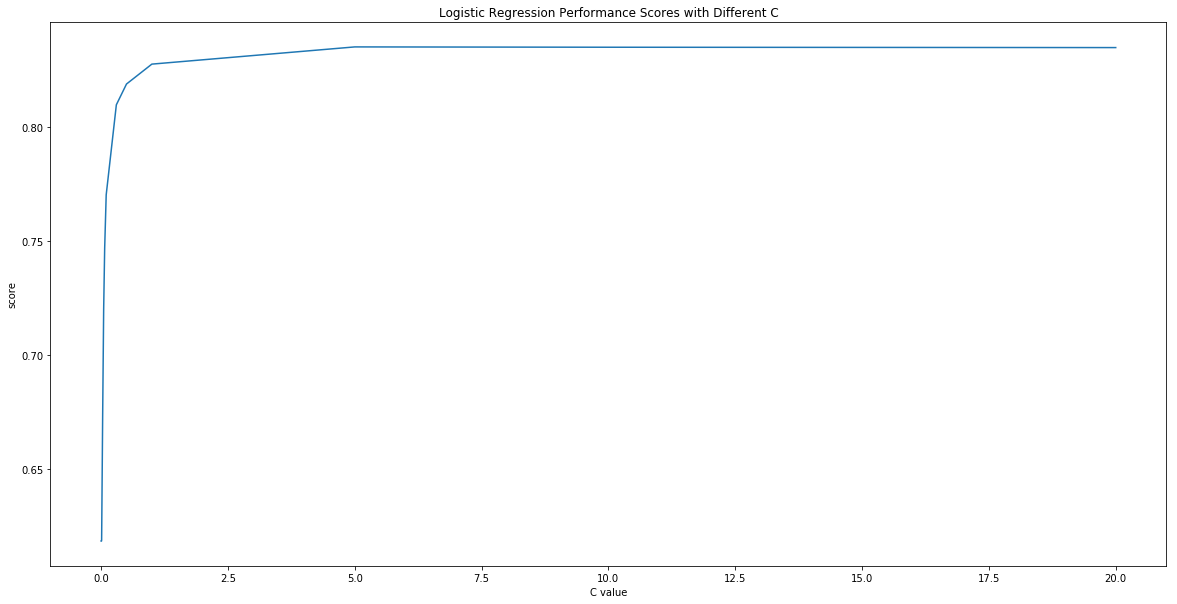

In [433]:
#We choose the logistic regression to perceed (tuning and drawing learning curve)

def GetScore1(model,name,X_train,y_train):
    clf=model.fit(X_train,y_train)
    results=cross_val_score(clf,X_train,y_train,cv=5)
    return results
C=[0.001,0.003,0.005,0.007,0.01,0.03,0.05,0.07,0.1,0.3,0.5,1,5,10,20]
score1=[]

for i in C:
    score1.append(GetScore1(LogisticRegression(C=i)))

plt.figure(figsize=(20,10))
plt.xlabel('C value')
plt.ylabel('score')
plt.title('Logistic Regression Performance Scores with Different C')
plt.plot(C, score1)

In [439]:
#Final Score
GetScore(LogisticRegression(C=5),'LR',X_train,y_train)

LR Score: 0.8375 (0.0042)


### Model 2

In [612]:
X=df2.drop(['description','Quality','points'],axis=1)
y=df2['Quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7)

In [613]:
#Use features except description to predict quality
GetScore(GradientBoostingClassifier(),'GBDT',X_train,y_train)
GetScore(lgb.LGBMClassifier(),'LightGBM',X_train,y_train)
GetScore(DecisionTreeClassifier(),'Decision Tree',X_train,y_train)
GetScore(ExtraTreesClassifier(),'ExtraTree',X_train,y_train)
GetScore(AdaBoostClassifier(),'Adaboost',X_train,y_train)

GBDT Score: 0.7699 (0.0032)
LightGBM Score: 0.7808 (0.0032)
Decision Tree Score: 0.7132 (0.0038)
ExtraTree Score: 0.7626 (0.0027)
Adaboost Score: 0.7618 (0.0024)


Text(0.5,1,'Receiver operating characteristic')

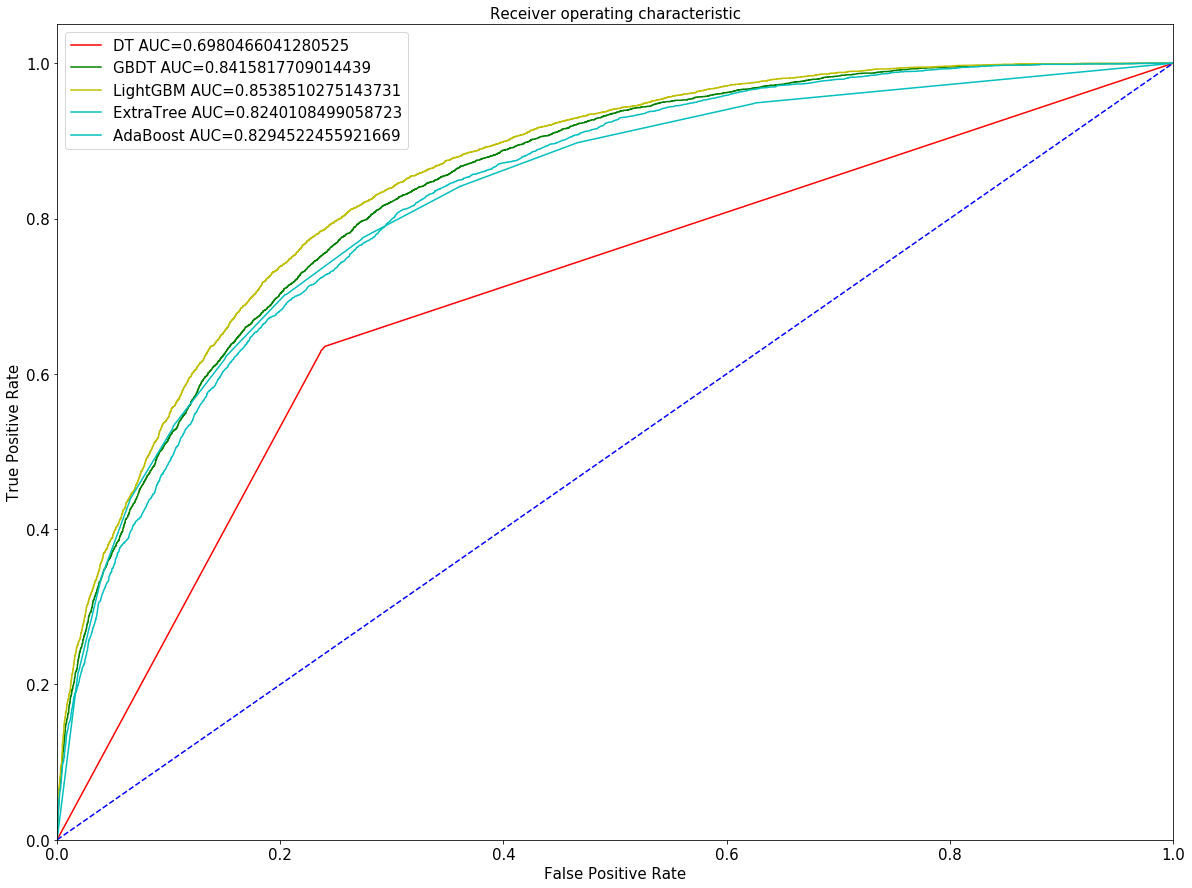

In [614]:
#Draw ROC curve of different models
from sklearn.metrics import roc_curve, auc

DT=DecisionTreeClassifier()
GT=GradientBoostingClassifier()
LG=lgb.LGBMClassifier()
EX=ExtraTreesClassifier()
ADA=AdaBoostClassifier()

DT.fit(X_train,y_train)
fpr1,tpr1,threshold1=roc_curve(y_val,DT.predict_proba(X_val)[:,1])
auc1=auc(fpr1,tpr1)

GT.fit(X_train,y_train)
fpr2,tpr2,threshold2=roc_curve(y_val,GT.predict_proba(X_val)[:,1])
auc2=auc(fpr2,tpr2)

LG.fit(X_train,y_train)
fpr3,tpr3,threshold3=roc_curve(y_val,LG.predict_proba(X_val)[:,1])
auc3=auc(fpr3,tpr3)

EX.fit(X_train,y_train)
fpr4,tpr4,threshold4=roc_curve(y_val,EX.predict_proba(X_val)[:,1])
auc4=auc(fpr4,tpr4)

ADA.fit(X_train,y_train)
fpr5,tpr5,threshold5=roc_curve(y_val,ADA.predict_proba(X_val)[:,1])
auc5=auc(fpr5,tpr5)


fig=plt.figure()
fig.set_size_inches(20,15)

plt.plot(fpr1,tpr1,'r',label='DT AUC={}'.format(auc1))
plt.plot(fpr2,tpr2,'g',label='GBDT AUC={}'.format(auc2))
plt.plot(fpr3,tpr3,'y',label='LightGBM AUC={}'.format(auc3))
plt.plot(fpr4,tpr4,'c',label='ExtraTree AUC={}'.format(auc4))
plt.plot(fpr5,tpr5,'c',label='AdaBoost AUC={}'.format(auc5))
plt.plot([0, 1], [0, 1], 'b', linestyle='--')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver operating characteristic',fontsize=15)

In [616]:
#Perform Randomized Search on LightGBM with selected number of estimators
clf_lgb = lgb.LGBMClassifier()
param_dist = {'n_estimators': [30,100,300,500,700,900,1000,1250,1500,2000,3000],
              'learning_rate': [0.001,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5],
              'max_depth': [-1,1,2,4,5,6,7,8,9,10,15,20,30,50,70,100,200],
              'colsample_bytree': [0.7,0.8,0.9,1],
              'subsample': [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
             }

n_iter_search = 50
random_search = RandomizedSearchCV(clf_lgb, 
                         param_distributions = param_dist,
                         cv = 5, 
                         verbose = 0, 
                         n_jobs = -1,
                         n_iter=n_iter_search)
start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 1682.38 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.789 (std: 0.002)
Parameters: {'subsample': 0.3, 'n_estimators': 1000, 'max_depth': 100, 'learning_rate': 0.05, 'colsample_bytree': 0.7}

Model with rank: 2
Mean validation score: 0.789 (std: 0.002)
Parameters: {'subsample': 0.8, 'n_estimators': 3000, 'max_depth': 70, 'learning_rate': 0.05, 'colsample_bytree': 1}

Model with rank: 3
Mean validation score: 0.788 (std: 0.002)
Parameters: {'subsample': 0.3, 'n_estimators': 900, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.9}

Model with rank: 4
Mean validation score: 0.788 (std: 0.002)
Parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 30, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

Model with rank: 5
Mean validation score: 0.788 (std: 0.003)
Parameters: {'subsample': 1, 'n_estimators': 2000, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Model with rank: 6
Mean valid

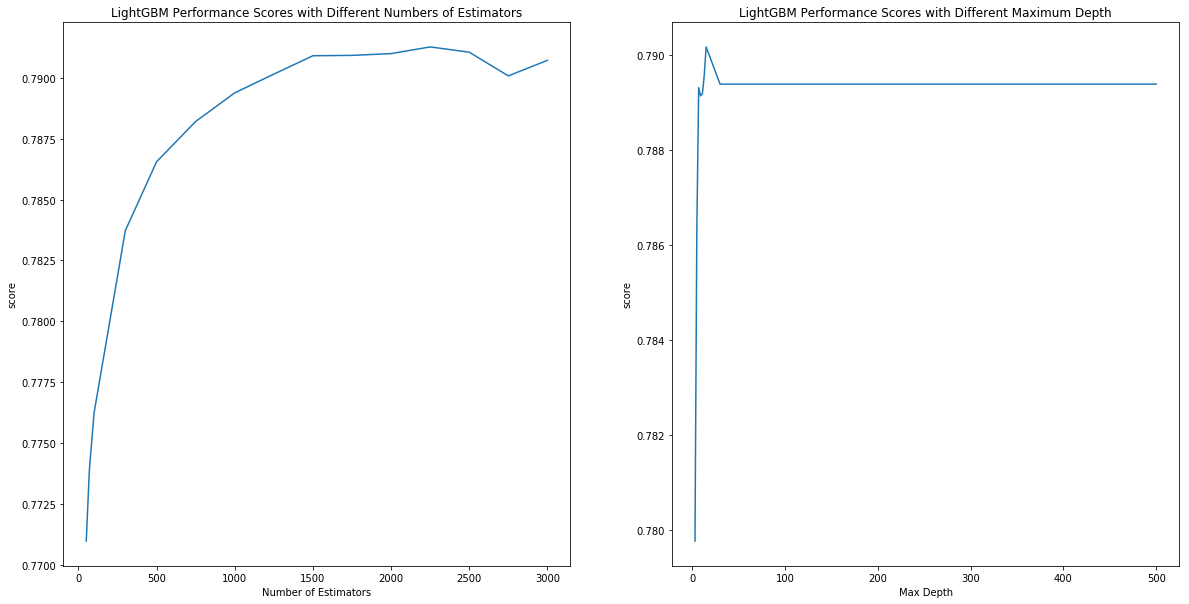

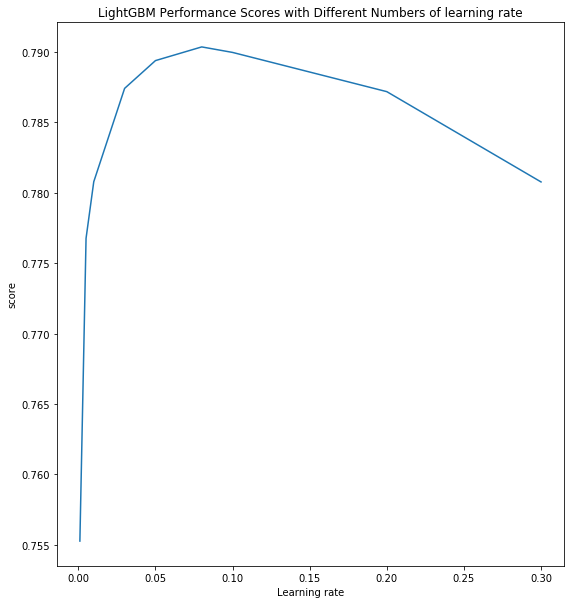

In [617]:
#Draw the learning curve of LightGBM
def GetScore1(model):
    kfold = KFold(n_splits=5, random_state=7)
    results = cross_val_score(model, X_train, y_train, cv=kfold)
    return results.mean()

n_estimators=[50,70,90,100,300,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000]
max_depth=[3,5,7,9,11,13,15,30,45,60,85,100,150,200,300,500]
learning_rate=[0.001,0.005,0.01,0.03,0.05,0.08,0.1,0.2,0.3]
score1=[]
score2=[]
score3=[]
for i in n_estimators:
    score1.append(GetScore1(lgb.LGBMClassifier(n_estimators=i,max_depth=100,learning_rate=0.05,subsample=0.3,colsample_bytree= 0.7)))
for i in max_depth:
    score2.append(GetScore1(lgb.LGBMClassifier(n_estimators=1000,max_depth=i,learning_rate=0.05,subsample=0.3,colsample_bytree= 0.7)))
for i in learning_rate:
    score3.append(GetScore1(lgb.LGBMClassifier(n_estimators=1000,max_depth=100,learning_rate=i,subsample=0.3,colsample_bytree= 0.7)))


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.xlabel('Number of Estimators')
plt.ylabel('score')
plt.title('LightGBM Performance Scores with Different Numbers of Estimators')
plt.plot(n_estimators, score1)

p = plt.subplot(1,2,2)
plt.plot(max_depth, score2)
plt.xlabel('Max Depth')
plt.ylabel('score')
plt.title('LightGBM Performance Scores with Different Maximum Depth')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.xlabel('Learning rate')
plt.ylabel('score')
plt.title('LightGBM Performance Scores with Different Numbers of learning rate')
plt.plot(learning_rate, score3)

In [619]:
#Final Result (we use the best result from the learning curve drawing process)
GetScore(lgb.LGBMClassifier(n_estimators=2250,
                            max_depth=100,
                            learning_rate=0.05,
                            subsample=0.3,
                            colsample_bytree= 0.7),'lightGBM after random search',X_train,y_train)

lightGBM after random search Score: 0.7919 (0.0022)


### Model3: VotingClassifier

In [620]:
#Define a soft voting classfier to combine the model1 and model2 and check the evaluation metrics

def Test_VotingClassifier(Data,model1,model2):   
    X_NLP=Data['description']
    TV=TfidfVectorizer(stop_words='english',binary=True,ngram_range=(1,2))
    TV.fit(X_NLP)
    X_NLP=TV.transform(X_NLP)
    
    X_Other=Data.drop(['description','Quality','points'],axis=1)
    y=Data['Quality']
    
    X_train1, X_test1, y_train, y_test = train_test_split(X_NLP, y, test_size=0.2, random_state=7)
    X_train2, X_test2, y_train, y_test = train_test_split(X_Other, y, test_size=0.2, random_state=7)
    
    model1.fit(X_train1,y_train)
    model2.fit(X_train2,y_train)
    
    prob1=model1.predict_proba(X_test1)
    prob2=model2.predict_proba(X_test2)
    pred1=model1.predict(X_test1)
    pred2=model2.predict(X_test2)
    finalpred=[]
    finalprob=[]
    
    for i in range(pred1.shape[0]):
        if pred1[i]==pred2[i]:
            finalpred.append(pred1[i])
            prob=max(prob1[i,pred1[i]],prob2[i,pred2[i]])
            if pred1[i]==0:
                finalprob.append([prob,1-prob])
            else:
                finalprob.append([1-prob,prob])
        else:
            if prob1[i,pred1[i]]>=prob2[i,pred2[i]]:
                                        finalpred.append(pred1[i])
                                        
                                        if pred1[i]==0:
                                            finalprob.append([prob1[i,pred1[i]],1-prob1[i,pred1[i]]])
                                        else:
                                            finalprob.append([1-prob1[i,pred1[i]],prob1[i,pred1[i]]])
            else:
                                        finalpred.append(pred2[i])
                                        prob=prob2[i,pred2[i]]
                                        if pred2[i]==0:
                                            finalprob.append([prob,1-prob])
                                        else:
                                            finalprob.append([1-prob,prob])
                                      
    fpr,tpr,threshold=roc_curve(y_test,np.array(finalprob)[:,1])
    auc1=auc(fpr,tpr)
    fig=plt.figure()
    
    fig.set_size_inches(20,15)

    plt.plot(fpr,tpr,'r',label='Final Voting Model AUC={}'.format(auc1))

    plt.plot([0, 1], [0, 1], 'b', linestyle='--')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=15)
    plt.ylabel('True Positive Rate',fontsize=15)
    plt.title('Receiver operating characteristic',fontsize=15)
    
    LR.fit(X_train1,y_train)
    fpr1,tpr1,threshold1=roc_curve(y_test,LR.predict_proba(X_test1)[:,1])
    auc1=auc(fpr1,tpr1)
    
    LG.fit(X_train2,y_train)
    fpr2,tpr2,threshold2=roc_curve(y_test,LG.predict_proba(X_test2)[:,1])
    auc2=auc(fpr2,tpr2)
    
    plt.plot(fpr1,tpr1,'g',label='Logistic Regression AUC={}'.format(auc1))
    plt.plot(fpr2,tpr2,'y',label='LightGBM AUC={}'.format(auc2))
    plt.legend(fontsize=15)

    print('accuracy: {}'.format(accuracy_score(y_test,finalpred)))
    print('\n'+'confusion matrix:')
    print(confusion_matrix(y_test,finalpred))
    print('\n'+'classification report:')
    print(classification_report(y_test,finalpred))

accuracy: 0.861878453038674

confusion matrix:
[[12144  1084]
 [ 1891  6420]]

classification report:
             precision    recall  f1-score   support

          0       0.87      0.92      0.89     13228
          1       0.86      0.77      0.81      8311

avg / total       0.86      0.86      0.86     21539



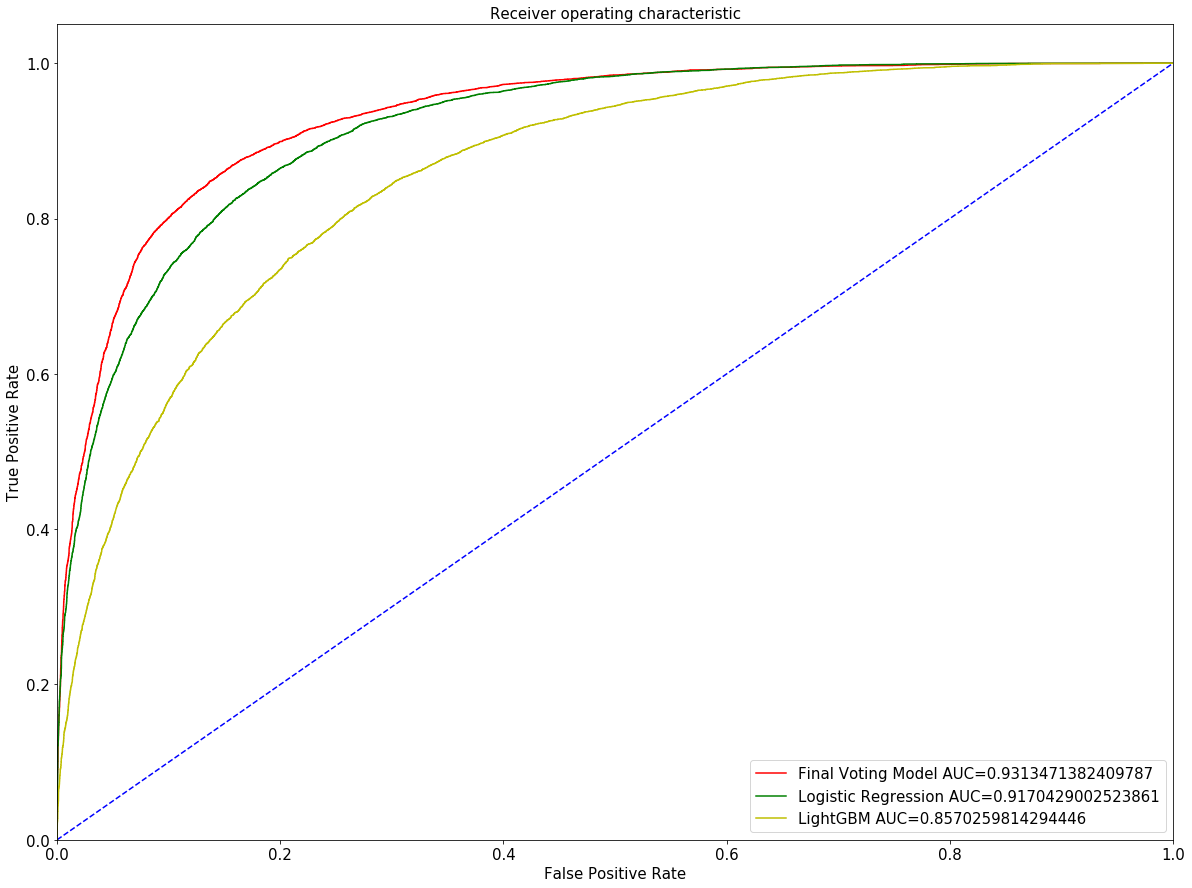

In [622]:
Test_VotingClassifier(df2,LogisticRegression(C=5),
                      lgb.LGBMClassifier(n_estimators=2250,
                            max_depth=100,
                            learning_rate=0.05,
                            subsample=0.3,
                            colsample_bytree= 0.7))